In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import shutil
from time import time
import torch
import pandas as pd
from copy import copy
from glob import glob
from PIL import Image, ImageFile
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import recgn_utils # utility script

In [2]:
# Verifica se CUDA está disponível 
gpu_on = torch.cuda.is_available()

if not gpu_on:
    print('Use a CPU. CUDA não está disponível...')
else:
    print('Use a GPU. CUDA está disponível...')

Use a GPU. CUDA está disponível...


In [3]:
# Configure alguns parametros:

# Path dos metadados e Modelo treinado com feature extraction, na Parte-2, 
# com 5 classes no enroll (11 imagens cada)
checkpoint_path_5cl = "../input/modelp2v8ep25/model_5cl_epoch_25_acc_80.0000_loss_0.7775.pth"

# Path dos metadados e Modelo treinado com feature extraction, na Parte-2, 
# com 20 classes no enroll (122 imagens cada)
checkpoint_path_20cl = "../input/modelp2v9ep25/model_20cl_epoch_25_acc_95.3846_loss_0.1295.pth"

batch_size = 64
num_workers = 0

In [4]:
# Define valores mean e std para normalizar as imagens
# TODO: Valores baseados no ImageNet. Idealmente calcular o mean e std do dataset original
img_mean = np.array((0.485, 0.456, 0.406))
img_std = np.array((0.229, 0.224, 0.225))

test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize(img_mean, 
                                                         img_std)])

In [5]:
# Unknowns
dogs_test_dir = '../input/dog-breed-recognition-v3/dogs/train'
dogs_test_set = datasets.ImageFolder(dogs_test_dir, transform=test_transforms)
dogs_test_loader = DataLoader(dogs_test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(f'Numero de imagens de Unknowns:', len(dogs_test_set))

# Knowns
enroll_test_dir = '../input/dog-breed-recognition-v3/dogs/recognition/test'
enroll_test_set = datasets.ImageFolder(enroll_test_dir, transform=test_transforms)
enroll_test_loader = DataLoader(enroll_test_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(f'Numero de imagens de Knowns:', len(enroll_test_set))

Numero de imagens de Unknowns: 17345
Numero de imagens de Knowns: 1030


In [6]:
# Funcao que carrega modelo treinado com feature extraction, na Parte-2 

def load_model(checkpoint_path, chpt_out_features):
    chpt_dict = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    # Recria model class
    model = models.resnet152(pretrained=True)
    classifier = nn.Sequential(nn.Linear(model.fc.in_features, 512),
                                  nn.ReLU(),
                                  nn.Linear(512, 256),
                                  nn.ReLU(),
                                  nn.Dropout(0.5),
                                  nn.Linear(256, chpt_out_features),
                                  nn.LogSoftmax(dim=1))
    model.fc = classifier
    model.load_state_dict(chpt_dict['model_state_dict'])
    return model

In [7]:
# Carrega modelos treinados com feature extraction, na Parte-2 
model_5cl = load_model(checkpoint_path_5cl, 5)
print(f'Camada FC do modelo treinado com 5 classes: {model_5cl.fc}\n')

model_20cl = load_model(checkpoint_path_20cl, 20)
print(f'Camada FC do modelo treinado com 20 classes: {model_20cl.fc}\n')

for param in model_5cl.parameters():
    param.requires_grad = False
for param in model_20cl.parameters():
    param.requires_grad = False

if gpu_on:
    model_5cl.cuda()
    model_20cl.cuda()

# Define loss function (categorical cross-entropy)
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html
criterion = nn.NLLLoss()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

Camada FC do modelo treinado com 5 classes: Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=5, bias=True)
  (6): LogSoftmax(dim=1)
)

Camada FC do modelo treinado com 20 classes: Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=256, out_features=20, bias=True)
  (6): LogSoftmax(dim=1)
)



Testando Modelo:: 100%|██████████| 17/17 [00:13<00:00,  1.29it/s]

Test Loss: 0.130886
Acuracia do Teste: 95% (982/1030)


Text(0.5, 1.0, 'Max outputs')

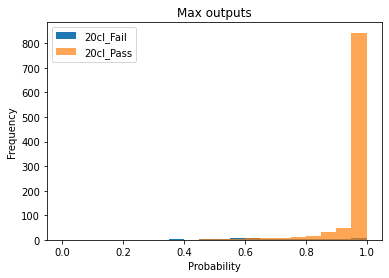

In [8]:
# Testa modelo treinado com loader de imagens de teste do tipo KNOWNS.
# TODO: montar loader com as 5 classes e fazer teste de KNOWNS para o model_5cl tambem, 
# cf. grafico em 'model_5cl_epoch_25_acc_80.0000_loss_0.7775.ipynb'.

prob_pass, prob_fail = recgn_utils.test_model(model_20cl, criterion, enroll_test_loader, gpu_on)

# Plota distribuição de probabilidades nos casos de pass e fail de teste do tipo KNOWNS
# Probabilidade = número na saída mais alta da rede após o teste

plt.hist(prob_fail, bins = np.arange(0,1.05,0.05)) 
plt.hist(prob_pass, bins = np.arange(0,1.05,0.05), alpha = 0.7) 
labels= ["20cl_Fail","20cl_Pass"]
plt.legend(labels)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Max outputs')

In [9]:
# Testa modelo da parte 2, presentando todos os Unknowns, ie cachorros de teste da parte 1
# Retorna distribuicao de probabilidades em todos os testes com Unknowns,
# onde a probailidade é o número na saída mais alta da rede após o teste
# Obs: Aqui nao interessa comparativo entre classe predita e classe esperada, mas apenas a probabilidade final

prob_unknown_5cl = recgn_utils.test_unknowns(dogs_test_loader, model_5cl, criterion, gpu_on)
prob_unknown_20cl = recgn_utils.test_unknowns(dogs_test_loader, model_20cl, criterion, gpu_on)

Testando Modelo:: 100%|██████████| 272/272 [02:22<00:00,  1.91it/s]


Text(0.5, 1.0, 'Max outputs')

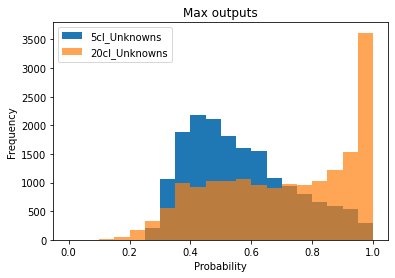

In [10]:
# Plota distribuição de probabilidades nos testes do tipo UNKNOWNS
# Probabilidade = número na saída mais alta da rede após o teste

plt.hist(prob_unknown_5cl, bins = np.arange(0,1.05,0.05)) 
plt.hist(prob_unknown_20cl, bins = np.arange(0,1.05,0.05), alpha = 0.7) 
labels= ["5cl_Unknowns","20cl_Unknowns"]
plt.legend(labels)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Max outputs')

In [11]:
def calc_quartiles(prob_list):
    df_probs = pd.DataFrame(np.array(prob_list))
    q1 = df_probs.quantile(0.25)[0]
    q2 = df_probs.quantile(0.5)[0]
    q3 = df_probs.quantile(0.75)[0]
    print(f'Q1 = {q1*100:4f}%\nQ2 = {q2*100:4f}%\nQ3 = {q3*100:4f}%\n')

print('Quartis de uma distribuição de probabilidades - saida da rede apresentada para Unknowns.\nJá nos testes de Knowns, a rede apresentou 83% de acuracia (para 5 classes de enroll).')
calc_quartiles(prob_unknown_5cl)
print('Quartis de uma distribuição de probabilidades - saida da rede apresentada para Unknowns.\nJá nos testes de Knowns, a rede apresentou 95% de acuracia (para 20 classes de enroll).')
calc_quartiles(prob_unknown_20cl)

Quartis de uma distribuição de probabilidades - saida da rede apresentada para Unknowns.
Já nos testes de Knowns, a rede apresentou 83% de acuracia (para 5 classes de enroll).
Q1 = 42.719412%
Q2 = 53.323096%
Q3 = 67.570972%

Quartis de uma distribuição de probabilidades - saida da rede apresentada para Unknowns.
Já nos testes de Knowns, a rede apresentou 95% de acuracia (para 20 classes de enroll).
Q1 = 51.361626%
Q2 = 73.477399%
Q3 = 92.878276%

